In [2]:
# === Parameters ===
ROOT = r"data"  # root with the three conditions

# Folders
import os, glob
from pathlib import Path
import numpy as np
from PIL import Image

from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import (
    disk, opening, closing, remove_small_objects,
    remove_small_holes, dilation
)
from skimage.measure import label, regionprops

FOLDERS = [
    ("untreated",   os.path.join(ROOT, "untreated", "green")),
    ("paclitaxel",  os.path.join(ROOT, "paclitaxel", "green")),
    ("vorinostat",  os.path.join(ROOT, "vorinostat", "green")),
]
IMG_EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

# Sampling
NUM_SAMPLES_PER_FOLDER = 1000
RANDOM_SEED = 42

# Post-process knobs (tuned for fluorescent nuclei)
GAUSS_SIGMA   = 1.2
OPEN_FOOT     = 1
CLOSE_FOOT    = 3
MIN_OBJ_FRAC  = 0.0003   # min area as fraction of H*W (drop specks)
MIN_HOLE_FRAC = 0.0006   # fill holes up to this area frac
DILATE_FOOT   = 1
PAD_PIXELS    = 2

# Output (one crop per image goes here)
CROPS_DIR  = "outputs_green/all_crops"
os.makedirs(CROPS_DIR, exist_ok=True)

# -------- Helpers --------
def list_images(folder, exts=IMG_EXTS):
    paths = []
    for ext in exts:
        paths.extend(glob.glob(os.path.join(folder, f"*{ext}")))
    return sorted(paths)

def to_gray_np(pil_img):
    arr = np.array(pil_img.convert("RGB"), dtype=np.float32)
    # Prefer blue channel for nuclear stain; fallback to average
    g = arr[..., 2] if arr.shape[-1] >= 3 else arr.mean(axis=-1)
    if g.max() > 1.0:
        g = g / 255.0
    return g

def seg_postprocess(gray):
    """gray in [0,1] -> cleaned binary mask."""
    H, W = gray.shape
    p  = gaussian(gray, sigma=GAUSS_SIGMA, preserve_range=True)
    t  = threshold_otsu(p) * 0.9
    b0 = p > t
    b1 = opening(b0, footprint=disk(OPEN_FOOT))
    b2 = closing(b1, footprint=disk(CLOSE_FOOT))
    b3 = remove_small_objects(b2, min_size=max(64, int(MIN_OBJ_FRAC * H * W)))
    b4 = remove_small_holes(b3, area_threshold=max(128, int(MIN_HOLE_FRAC * H * W)))
    bf = dilation(b4, footprint=disk(DILATE_FOOT))
    return bf

def largest_region_bbox(bin_mask):
    lab = label(bin_mask)
    props = list(regionprops(lab))
    if not props:
        return None
    r = max(props, key=lambda rr: rr.area)
    y0, x0, y1, x1 = r.bbox
    return (y0, x0, y1, x1), int(r.area)

def crop_from_bbox(pil_img, bbox, pad=PAD_PIXELS):
    H, W = pil_img.size[1], pil_img.size[0]
    y0, x0, y1, x1 = bbox
    y0p, x0p = max(0, y0 - pad), max(0, x0 - pad)
    y1p, x1p = min(H, y1 + pad), min(W, x1 + pad)
    return pil_img.crop((x0p, y0p, x1p, y1p))

# -------- Main --------
rng = np.random.default_rng(RANDOM_SEED)
saved = 0

for cond, folder in FOLDERS:
    all_imgs = list_images(folder)
    if len(all_imgs) == 0:
        print(f"[INFO] No images in {folder}")
        continue

#     k = min(NUM_SAMPLES_PER_FOLDER, len(all_imgs))
    k = len(all_imgs)
    
    sel_idxs = rng.choice(len(all_imgs), size=k, replace=False)
    imgs = [all_imgs[i] for i in sel_idxs]
    print(f"[{cond}] Using {len(imgs)} / {len(all_imgs)} images from {folder}")

    for ip in imgs:
        try:
            pil = Image.open(ip).convert("RGB")
        except Exception as e:
            print(f"[WARN] Could not open {ip}: {e}")
            continue

        gray = to_gray_np(pil)
        bin_mask = seg_postprocess(gray)
        largest = largest_region_bbox(bin_mask)
        if largest is None:
            # nothing found in this image
            continue

        bbox, area = largest
        crop = crop_from_bbox(pil, bbox, pad=PAD_PIXELS)

        stem = Path(ip).stem
        out_name = f"{cond}__{stem}.png"
        out_path = os.path.join(CROPS_DIR, out_name)
        crop.save(out_path)
        saved += 1

print(f"[DONE] Saved {saved} largest-segment crops to {CROPS_DIR}")


[untreated] Using 3976 / 3976 images from data/untreated/green
[paclitaxel] Using 4422 / 4422 images from data/paclitaxel/green
[vorinostat] Using 4462 / 4462 images from data/vorinostat/green
[DONE] Saved 12853 largest-segment crops to outputs_green/all_crops


In [5]:
# Core
import os, glob, json, math
from pathlib import Path

import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Vision / features / clustering
import torchvision.transforms as T
import timm
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Segmentation post-processing
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import (
    disk, opening, closing, remove_small_objects,
    remove_small_holes, dilation
)
from skimage.measure import label, regionprops


In [8]:
# # === Parameters for Step 2 ===
# VIT_MODEL = "vit_base_patch16_224"   # timm name
# VIT_SIZE  = 224
# VIT_MEAN  = (0.485, 0.456, 0.406)    # ImageNet mean
# VIT_STD   = (0.229, 0.224, 0.225)    # ImageNet std
# META_JSON = "outputs_green/crops_meta.json"

# # === Code for Step 2 ===
# with open(META_JSON, "r") as f:
#     meta = json.load(f)
# crop_paths = [m["crop_path"] for m in meta]

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# vit = timm.create_model(VIT_MODEL, pretrained=True, num_classes=0).eval().to(device)

# crop_tf = T.Compose([
#     T.Resize((VIT_SIZE, VIT_SIZE), interpolation=T.InterpolationMode.BILINEAR),
#     T.ToTensor(),
#     T.Normalize(mean=VIT_MEAN, std=VIT_STD),
# ])

# def crop_to_feature(path):
#     pil = Image.open(path).convert("RGB")
#     x = crop_tf(pil).unsqueeze(0).to(device)
#     with torch.no_grad():
#         f = vit(x).squeeze(0).cpu().numpy()  # [D] e.g., 768
#     return f

# X_feats = np.stack([crop_to_feature(p) for p in crop_paths], axis=0)
# print("Feature matrix:", X_feats.shape)


In [6]:
# === Parameters ===
CROPS_DIR = "outputs_green/all_crops"   # single folder with all images
IMG_EXTS  = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

# VIT_MODEL = "vit_base_patch16_224"
VIT_MODEL = "vit_large_patch16_224"   # has 1024 features
VIT_SIZE  = 224
VIT_MEAN  = (0.485, 0.456, 0.406)
VIT_STD   = (0.229, 0.224, 0.225)

MAX_IMAGES = 10#None  # limit per category (optional)

OUTPUT_FILES = {
    "paclitaxel": "paclitaxel_image_emd.tsv",
    "untreated": "untreated_image_emd.tsv",
    "vorinostat": "vorinostat_image_emd.tsv"
}

# === Code ===
import os, glob
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as T
import timm
import pandas as pd

def list_crop_paths(folder, exts=IMG_EXTS):
    paths = []
    for e in exts:
        paths.extend(glob.glob(os.path.join(folder, f"*{e}")))
    return sorted(paths)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit = timm.create_model(VIT_MODEL, pretrained=True, num_classes=0).eval().to(device)

crop_tf = T.Compose([
    T.Resize((VIT_SIZE, VIT_SIZE), interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize(mean=VIT_MEAN, std=VIT_STD),
])

def crop_to_feature(path):
    pil = Image.open(path).convert("RGB")
    x = crop_tf(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        f = vit(x).squeeze(0).cpu().numpy()
    return f

# Collect all paths
crop_paths = list_crop_paths(CROPS_DIR)
print(f"Found {len(crop_paths)} total crops in {CROPS_DIR}")

# Containers for each category
data_by_cat = {cat: [] for cat in OUTPUT_FILES}

# Process
for i, path in enumerate(crop_paths, 1):
    fname = os.path.basename(path)
    cat = fname.split("__")[0].lower()  # extract category from filename
    if cat not in data_by_cat:
        continue  # skip unknown categories
    
    feat = crop_to_feature(path)
    data_by_cat[cat].append((fname, feat))

    if i % 100 == 0:
        print(f"Processed {i}/{len(crop_paths)}")

# Save per category
for cat, entries in data_by_cat.items():
    if not entries:
        continue
    ids, feats = zip(*entries)
    feats = np.stack(feats, axis=0)
    df = pd.DataFrame(feats, columns=[f"f{i}" for i in range(feats.shape[1])])
    df.insert(0, "id", ids)
    out_path = os.path.join(CROPS_DIR, OUTPUT_FILES[cat])
    df.to_csv(out_path, sep="\t", index=False)
    print(f"Saved {out_path}, shape={df.shape}")


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Found 12853 total crops in outputs_green/all_crops
Processed 100/12853
Processed 200/12853
Processed 300/12853
Processed 400/12853
Processed 500/12853
Processed 600/12853
Processed 700/12853
Processed 800/12853
Processed 900/12853
Processed 1000/12853
Processed 1100/12853
Processed 1200/12853
Processed 1300/12853
Processed 1400/12853
Processed 1500/12853
Processed 1600/12853
Processed 1700/12853
Processed 1800/12853
Processed 1900/12853
Processed 2000/12853
Processed 2100/12853
Processed 2200/12853
Processed 2300/12853
Processed 2400/12853
Processed 2500/12853
Processed 2600/12853
Processed 2700/12853
Processed 2800/12853
Processed 2900/12853
Processed 3000/12853
Processed 3100/12853
Processed 3200/12853
Processed 3300/12853
Processed 3400/12853
Processed 3500/12853
Processed 3600/12853
Processed 3700/12853
Processed 3800/12853
Processed 3900/12853
Processed 4000/12853
Processed 4100/12853
Processed 4200/12853
Processed 4300/12853
Processed 4400/12853
Processed 4500/12853
Processed 460

In [7]:
!cp outputs_green/all_crops/paclitaxel_image_emd.tsv outputs_green/paclitaxel_image_emd.tsv
!cp outputs_green/all_crops/vorinostat_image_emd.tsv outputs_green/vorinostat_image_emd.tsv
!cp outputs_green/all_crops/untreated_image_emd.tsv outputs_green/untreated_image_emd.tsv

In [4]:

######
import pandas as pd

# === Load file2 (dictionary source) ===
# file2.csv has columns: Gene_Name_HPA, image
file2 = pd.read_csv("outputs_green/tmp/manifest_paclitaxel.csv", dtype=str)

# Normalize keys by stripping trailing underscores
file2["image_norm"] = file2["image"].str.rstrip("_")

# Build dictionary: {normalized image : gene name}
mapping = dict(zip(file2["image_norm"], file2["Gene_Name_HPA"]))

# === Load file1 (input) ===
# file1.csv has column: id
file1 = pd.read_csv("outputs_green/tmp/paclitaxel_image_emd_1.csv", dtype=str)

# Normalize file1 ids too (remove trailing underscore if any)
file1["id_norm"] = file1["id"].str.rstrip("_")

# Lookup gene name using the dictionary
file1["Gene_Name_HPA"] = file1["id_norm"].map(mapping).fillna("NA")

# Keep only the desired columns
final = file1[["id", "Gene_Name_HPA"]]

# === Save output ===
final.to_csv("outputs_green/tmp/file1_with_genes.csv", index=False)

print("✅ Saved merged file as file1_with_genes.csv")



✅ Saved merged file as file1_with_genes.csv


In [5]:
import pandas as pd

# Load the CSV
df = pd.read_csv("outputs_green/file1_paclitaxel.csv", dtype=str)

# Save as TSV
df.to_csv("outputs_green/file1_paclitaxel.tsv", sep="\t", index=False)

print("✅ Converted file1_paclitaxel.csv → file1_paclitaxel.tsv")


✅ Converted file1_paclitaxel.csv → file1_paclitaxel.tsv


In [10]:
import numpy as np
import os

# crop_paths = list of image file paths
# X_feats = features array from Step 2

# Extract just the file names (or keep full paths if you prefer)
file_names = [os.path.basename(p) for p in crop_paths]

# Save both features and names
np.savez("X_feats_with_names.npz", features=X_feats, names=file_names)

print(f"Saved {len(file_names)} features to X_feats_with_names.npz")


NameError: name 'X_feats' is not defined

In [ ]:
import numpy as np
import pandas as pd

# Load npz with features and file names
data = np.load("X_feats_with_names.npz", allow_pickle=True)
X_feats = data["features"]
file_names = data["names"]

# Create DataFrame
df = pd.DataFrame(X_feats)
df.insert(0, "filename", file_names)  # Add file names as first column

# Save to CSV
df.to_csv("X_feats_with_names.csv", index=False)

print("Saved to X_feats_with_names.csv")


In [11]:
# === Parameters for Step 3 ===
UMAP_NCOMP    = 32
UMAP_NEIGHBORS= 15
K_LIST        = [5, 10, 20, 50]
RANDOM_STATE  = 42

# === Code for Step 3 ===
umap = UMAP(n_components=UMAP_NCOMP, n_neighbors=UMAP_NEIGHBORS,
            metric="cosine", random_state=RANDOM_STATE)
X_umap = umap.fit_transform(X_feats)

def eval_clusters(X, labels):
    uniq = np.unique(labels)
    if len(uniq) < 2 or len(uniq) >= len(labels):
        return {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan}
    return {
        "silhouette": silhouette_score(X, labels, metric="euclidean"),
        "calinski_harabasz": calinski_harabasz_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels),
    }

scores = {}
best_by_sil = (None, -np.inf)

for K in K_LIST:
    km = KMeans(n_clusters=K, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_umap)
    sc = eval_clusters(X_umap, labels)
    scores[K] = sc
    print(f"K={K:>2} | silhouette={sc['silhouette']:.4f} | "
          f"CH={sc['calinski_harabasz']:.1f} | DB={sc['davies_bouldin']:.3f}")
    if not math.isnan(sc["silhouette"]) and sc["silhouette"] > best_by_sil[1]:
        best_by_sil = (K, sc["silhouette"])

best_K = best_by_sil[0] if best_by_sil[0] is not None else K_LIST[0]
print(f"\nSelected K by silhouette: {best_K}")

# Fit final model at selected K
kmeans_final = KMeans(n_clusters=best_K, random_state=RANDOM_STATE, n_init=10).fit(X_umap)
labels_final = kmeans_final.labels_


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K= 5 | silhouette=0.4091 | CH=612.8 | DB=0.809


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K=10 | silhouette=0.4197 | CH=655.7 | DB=0.835


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K=20 | silhouette=0.4198 | CH=636.5 | DB=0.840


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K=50 | silhouette=0.3485 | CH=592.8 | DB=0.879

Selected K by silhouette: 20


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [17]:
import json

# === Parameters ===
json_file1 = "outputs/crops_meta.json"
json_file2 = "outputs/crops_meta200.json"
merged_json_file = "outputs/crops_meta300.json"

# === Load both JSON files ===
with open(json_file1, "r") as f1:
    data1 = json.load(f1)

with open(json_file2, "r") as f2:
    data2 = json.load(f2)

print(f"Loaded {len(data1)} items from {json_file1}")
print(f"Loaded {len(data2)} items from {json_file2}")

# === Merge and remove duplicates ===
# We'll use 'crop_path' as the unique key (change to 'source_path' if you prefer)
merged_dict = {item["crop_path"]: item for item in (data1 + data2)}

merged_list = list(merged_dict.values())

print(f"Merged list has {len(merged_list)} unique items")

# === Save merged JSON ===
with open(merged_json_file, "w") as f:
    json.dump(merged_list, f, indent=2)

print(f"Saved merged JSON to {merged_json_file}")


Loaded 298 items from outputs/crops_meta.json
Loaded 600 items from outputs/crops_meta200.json
Merged list has 898 unique items
Saved merged JSON to outputs/crops_meta300.json


In [ ]:
# === Parameters for Step 2 ===
VIT_MODEL = "vit_base_patch16_224"   # timm name
VIT_SIZE  = 224
VIT_MEAN  = (0.485, 0.456, 0.406)    # ImageNet mean
VIT_STD   = (0.229, 0.224, 0.225)    # ImageNet std
META_JSON = "llema_outputs/crops_meta300.json"

# === Code for Step 2 ===
with open(META_JSON, "r") as f:
    meta = json.load(f)
crop_paths = [m["crop_path"] for m in meta]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit = timm.create_model(VIT_MODEL, pretrained=True, num_classes=0).eval().to(device)

crop_tf = T.Compose([
    T.Resize((VIT_SIZE, VIT_SIZE), interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize(mean=VIT_MEAN, std=VIT_STD),
])

def crop_to_feature(path):
    pil = Image.open(path).convert("RGB")
    x = crop_tf(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        f = vit(x).squeeze(0).cpu().numpy()  # [D] e.g., 768
    return f

X_feats = np.stack([crop_to_feature(p) for p in crop_paths], axis=0)
print("Feature matrix:", X_feats.shape)


Feature matrix: (898, 768)


In [19]:
# === Parameters for Step 3 ===
UMAP_NCOMP    = 32
UMAP_NEIGHBORS= 15
K_LIST        = [5, 10, 20, 50]
RANDOM_STATE  = 7

# === Code for Step 3 ===
umap = UMAP(n_components=UMAP_NCOMP, n_neighbors=UMAP_NEIGHBORS,
            metric="cosine", random_state=RANDOM_STATE)
X_umap = umap.fit_transform(X_feats)

def eval_clusters(X, labels):
    uniq = np.unique(labels)
    if len(uniq) < 2 or len(uniq) >= len(labels):
        return {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan}
    return {
        "silhouette": silhouette_score(X, labels, metric="euclidean"),
        "calinski_harabasz": calinski_harabasz_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels),
    }

scores = {}
best_by_sil = (None, -np.inf)

for K in K_LIST:
    km = KMeans(n_clusters=K, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_umap)
    sc = eval_clusters(X_umap, labels)
    scores[K] = sc
    print(f"K={K:>2} | silhouette={sc['silhouette']:.4f} | "
          f"CH={sc['calinski_harabasz']:.1f} | DB={sc['davies_bouldin']:.3f}")
    if not math.isnan(sc["silhouette"]) and sc["silhouette"] > best_by_sil[1]:
        best_by_sil = (K, sc["silhouette"])

best_K = best_by_sil[0] if best_by_sil[0] is not None else K_LIST[0]
print(f"\nSelected K by silhouette: {best_K}")

# Fit final model at selected K
kmeans_final = KMeans(n_clusters=best_K, random_state=RANDOM_STATE, n_init=10).fit(X_umap)
labels_final = kmeans_final.labels_


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K= 5 | silhouette=0.4635 | CH=1655.4 | DB=0.584


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=10 | silhouette=0.3763 | CH=1604.3 | DB=0.837


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=20 | silhouette=0.3845 | CH=1596.7 | DB=0.872


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K=50 | silhouette=0.3548 | CH=1479.8 | DB=0.931

Selected K by silhouette: 5


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [24]:
# === Parameters for Step 2 ===
VIT_MODEL = "vit_base_patch16_224"   # timm name
VIT_SIZE  = 224
VIT_MEAN  = (0.485, 0.456, 0.406)    # ImageNet mean
VIT_STD   = (0.229, 0.224, 0.225)    # ImageNet std
META_JSON = "outputs/crops_meta500.json"

# === Code for Step 2 ===
with open(META_JSON, "r") as f:
    meta = json.load(f)
crop_paths = [m["crop_path"] for m in meta]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit = timm.create_model(VIT_MODEL, pretrained=True, num_classes=0).eval().to(device)

crop_tf = T.Compose([
    T.Resize((VIT_SIZE, VIT_SIZE), interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize(mean=VIT_MEAN, std=VIT_STD),
])

def crop_to_feature(path):
    pil = Image.open(path).convert("RGB")
    x = crop_tf(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        f = vit(x).squeeze(0).cpu().numpy()  # [D] e.g., 768
    return f

X_feats = np.stack([crop_to_feature(p) for p in crop_paths], axis=0)
print("Feature matrix:", X_feats.shape)


Feature matrix: (1491, 768)


In [33]:
# === Parameters for Step 3 ===
UMAP_NCOMP    = 32
UMAP_NEIGHBORS= 15
K_LIST        = [1, 3, 5, 10, 50]
RANDOM_STATE  = 7

# === Code for Step 3 ===
umap = UMAP(n_components=UMAP_NCOMP, n_neighbors=UMAP_NEIGHBORS,
            metric="cosine", random_state=RANDOM_STATE)
X_umap = umap.fit_transform(X_feats)

def eval_clusters(X, labels):
    uniq = np.unique(labels)
    if len(uniq) < 2 or len(uniq) >= len(labels):
        return {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan}
    return {
        "silhouette": silhouette_score(X, labels, metric="euclidean"),
        "calinski_harabasz": calinski_harabasz_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels),
    }

scores = {}
best_by_sil = (None, -np.inf)

for K in K_LIST:
    km = KMeans(n_clusters=K, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_umap)
    sc = eval_clusters(X_umap, labels)
    scores[K] = sc
    print(f"K={K:>2} | silhouette={sc['silhouette']:.4f} | "
          f"CH={sc['calinski_harabasz']:.1f} | DB={sc['davies_bouldin']:.3f}")
    if not math.isnan(sc["silhouette"]) and sc["silhouette"] > best_by_sil[1]:
        best_by_sil = (K, sc["silhouette"])

best_K = best_by_sil[0] if best_by_sil[0] is not None else K_LIST[0]
print(f"\nSelected K by silhouette: {best_K}")

# Fit final model at selected K
kmeans_final = KMeans(n_clusters=best_K, random_state=RANDOM_STATE, n_init=10).fit(X_umap)
labels_final = kmeans_final.labels_


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


K= 1 | silhouette=nan | CH=nan | DB=nan


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


K= 3 | silhouette=0.4435 | CH=2062.3 | DB=0.767


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


K= 5 | silhouette=0.4177 | CH=2355.0 | DB=0.658


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


K=10 | silhouette=0.3747 | CH=2712.5 | DB=0.810


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


K=50 | silhouette=0.3280 | CH=2130.8 | DB=0.981

Selected K by silhouette: 3


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [35]:
import json

# === Parameters ===
json_file1 = "outputs/crops_meta300.json"
json_file2 = "outputs/crops_meta500.json"
merged_json_file = "outputs/crops_meta800.json"

# === Load both JSON files ===
with open(json_file1, "r") as f1:
    data1 = json.load(f1)

with open(json_file2, "r") as f2:
    data2 = json.load(f2)

print(f"Loaded {len(data1)} items from {json_file1}")
print(f"Loaded {len(data2)} items from {json_file2}")

# === Merge and remove duplicates ===
# We'll use 'crop_path' as the unique key (change to 'source_path' if you prefer)
merged_dict = {item["crop_path"]: item for item in (data1 + data2)}

merged_list = list(merged_dict.values())

print(f"Merged list has {len(merged_list)} unique items")

# === Save merged JSON ===
with open(merged_json_file, "w") as f:
    json.dump(merged_list, f, indent=2)

print(f"Saved merged JSON to {merged_json_file}")


Loaded 898 items from outputs/crops_meta300.json
Loaded 1491 items from outputs/crops_meta500.json
Merged list has 2389 unique items
Saved merged JSON to outputs/crops_meta800.json


In [11]:
#llema
# === Parameters for Step 2 (no JSON) ===
CROPS_DIR = "llema_outputs/all_crops"      # folder containing your cropped PNG/JPGs
IMG_EXTS  = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

VIT_MODEL = "vit_base_patch16_224"   # timm model name
VIT_SIZE  = 224
VIT_MEAN  = (0.485, 0.456, 0.406)    # ImageNet mean
VIT_STD   = (0.229, 0.224, 0.225)    # ImageNet std

# Optional: limit how many images to embed (None = all)
MAX_IMAGES = None

# === Code for Step 2 ===
import os, glob
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as T
import timm

def list_crop_paths(folder, exts=IMG_EXTS):
    paths = []
    for e in exts:
        paths.extend(glob.glob(os.path.join(folder, f"*{e}")))
    return sorted(paths)

crop_paths = list_crop_paths(CROPS_DIR)
if MAX_IMAGES is not None:
    crop_paths = crop_paths[:MAX_IMAGES]
print(f"Found {len(crop_paths)} crops in {CROPS_DIR}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit = timm.create_model(VIT_MODEL, pretrained=True, num_classes=0).eval().to(device)

crop_tf = T.Compose([
    T.Resize((VIT_SIZE, VIT_SIZE), interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize(mean=VIT_MEAN, std=VIT_STD),
])

def crop_to_feature(path):
    pil = Image.open(path).convert("RGB")
    x = crop_tf(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        f = vit(x).squeeze(0).cpu().numpy()  # [D], e.g. 768 for ViT-B/16
    return f

X_feats = np.stack([crop_to_feature(p) for p in crop_paths], axis=0)
print("Feature matrix:", X_feats.shape)


Found 2999 crops in llema_outputs/all_crops
Feature matrix: (2999, 768)


In [23]:
import numpy as np
import os

# crop_paths = list of image file paths
# X_feats = features array from Step 2

# Extract just the file names (or keep full paths if you prefer)
file_names = [os.path.basename(p) for p in crop_paths]

# Save both features and names
np.savez("X_feats_with_names.npz", features=X_feats, names=file_names)

print(f"Saved {len(file_names)} features to X_feats_with_names.npz")


Saved 2999 features to X_feats_with_names.npz


In [24]:
import numpy as np

# Load saved file
data = np.load("X_feats_with_names.npz", allow_pickle=True)
X_feats = data["features"]
file_names = data["names"]

# Show first row
print("File name:", file_names[0])
print("Feature vector shape:", X_feats[0].shape)
print("Feature vector values:", X_feats[0])


File name: paclitaxel__B2AI_1_Paclitaxel_A10_R13_z02_blue.png
Feature vector shape: (768,)
Feature vector values: [ 6.19353354e-02  1.90764278e-01 -1.00151455e+00  5.28603792e-01
 -7.26332605e-01  7.09695220e-02  5.62214553e-01 -6.09554648e-01
  5.19683421e-01 -9.80499566e-01  9.92379308e-01 -9.85113919e-01
 -5.24766862e-01 -1.45838642e+00  6.53850019e-01 -3.03450918e+00
  9.13903892e-01 -1.90042183e-01  1.15548170e+00  9.08597708e-01
  1.33234251e+00 -3.79904002e-01  4.32815731e-01 -5.24188936e-01
  1.51272142e+00 -1.59324956e+00  1.72612309e-01 -2.00330901e+00
 -3.45190549e+00 -6.26982868e-01  2.50206351e+00 -7.47961938e-01
  1.95800471e+00  5.07168710e-01 -6.13208115e-01  3.05708313e+00
  1.76313770e+00  1.32372689e+00 -7.89190456e-02  6.34447873e-01
  1.46654642e+00 -1.13503432e+00  1.36931276e+00  1.25324202e+00
  1.27057874e+00  8.41451347e-01 -5.32672135e-03  6.32853329e-01
 -4.04137701e-01 -7.59022415e-01 -1.47579348e+00  1.34980842e-01
 -2.04920694e-01 -3.30796897e-01  2.70975

In [25]:
import numpy as np
import pandas as pd

# Load npz with features and file names
data = np.load("X_feats_with_names.npz", allow_pickle=True)
X_feats = data["features"]
file_names = data["names"]

# Create DataFrame
df = pd.DataFrame(X_feats)
df.insert(0, "filename", file_names)  # Add file names as first column

# Save to CSV
df.to_csv("X_feats_with_names.csv", index=False)

print("Saved to X_feats_with_names.csv")


Saved to X_feats_with_names.csv


In [13]:
# === Parameters for Step 3 ===
UMAP_NCOMP    = 32
UMAP_NEIGHBORS= 15
K_LIST        = [1, 3, 5, 10, 50]
RANDOM_STATE  = 7

# === Imports ===
import math
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from umap import UMAP  # requires: pip install umap-learn

# === Code for Step 3 ===
umap = UMAP(n_components=UMAP_NCOMP, n_neighbors=UMAP_NEIGHBORS,
            metric="cosine", random_state=RANDOM_STATE)
X_umap = umap.fit_transform(X_feats)

def eval_clusters(X, labels):
    uniq = np.unique(labels)
    if len(uniq) < 2 or len(uniq) >= len(labels):
        return {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan}
    return {
        "silhouette": silhouette_score(X, labels, metric="euclidean"),
        "calinski_harabasz": calinski_harabasz_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels),
    }

scores = {}
best_by_sil = (None, -np.inf)

for K in K_LIST:
    km = KMeans(n_clusters=K, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_umap)
    sc = eval_clusters(X_umap, labels)
    scores[K] = sc
    print(f"K={K:>2} | silhouette={sc['silhouette']:.4f} | "
          f"CH={sc['calinski_harabasz']:.1f} | DB={sc['davies_bouldin']:.3f}")
    if not math.isnan(sc["silhouette"]) and sc["silhouette"] > best_by_sil[1]:
        best_by_sil = (K, sc["silhouette"])

best_K = best_by_sil[0] if best_by_sil[0] is not None else K_LIST[0]
print(f"\nSelected K by silhouette: {best_K}")

# Fit final model at selected K
kmeans_final = KMeans(n_clusters=best_K, random_state=RANDOM_STATE, n_init=10).fit(X_umap)
labels_final = kmeans_final.labels_


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


K= 1 | silhouette=nan | CH=nan | DB=nan


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


K= 3 | silhouette=0.4237 | CH=3059.6 | DB=0.823


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


K= 5 | silhouette=0.4104 | CH=3225.1 | DB=0.673


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


K=10 | silhouette=0.3657 | CH=4691.8 | DB=0.740


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


K=50 | silhouette=0.3364 | CH=4087.2 | DB=0.947

Selected K by silhouette: 3


c:\Users\s229769\.conda\envs\sentiment_ana\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


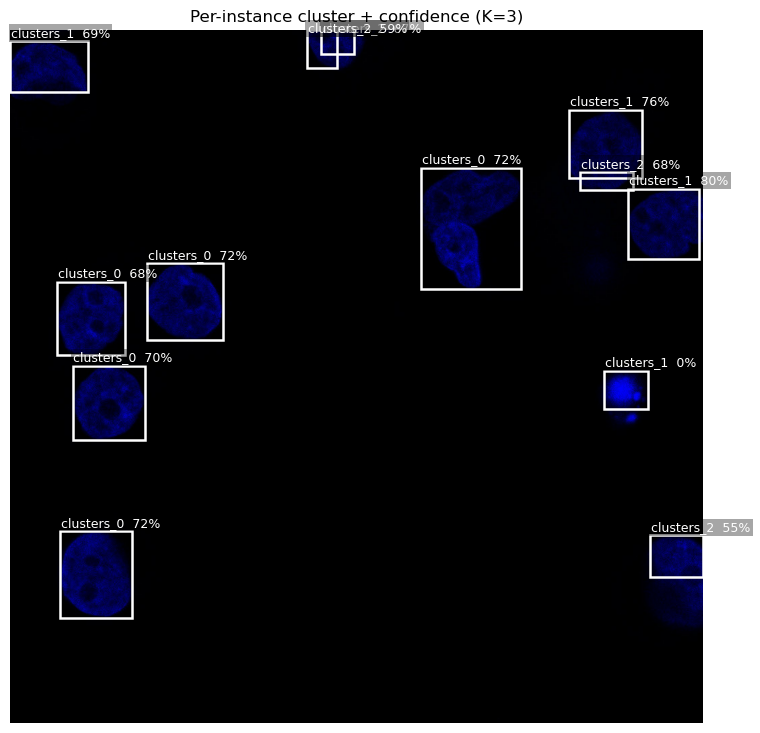

In [19]:
# =========================
# STEP 5 — Per-instance clustering overlay with inner-box removal
# =========================

# --- Imports ---
import math, numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import torch, torchvision.transforms as T
import timm

from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import opening, closing, dilation, remove_small_objects, remove_small_holes, disk
from skimage.measure import label, regionprops

from umap import UMAP  # used only if we must refit

# --- Parameters ---
SAMPLE_IMAGE = r"C:\Users\s229769\Downloads\cm4ai\cm4ai\untreated\blue\B2AI_3_untreated_E1_R8_z01_blue.jpg"

GAUSS_SIGMA   = 1.2
OPEN_FOOT     = 1
CLOSE_FOOT    = 3
MIN_OBJ_FRAC  = 0.0003
MIN_HOLE_FRAC = 0.0006
DILATE_FOOT   = 1
PAD_PIXELS    = 2

VIT_MODEL     = "vit_base_patch16_224"
VIT_SIZE      = 224
VIT_MEAN      = (0.485, 0.456, 0.406)
VIT_STD       = (0.229, 0.224, 0.225)

CONF_HIDE_TH  = 0.0   # hide labels below this prob
TEXT_OFFSET_PX = 14

# These should match Step 3
UMAP_NCOMP     = 32
UMAP_NEIGHBORS = 15
RANDOM_STATE   = 7

# --- Device & (re)instantiate ViT if not present ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    vit  # noqa
except NameError:
    vit = timm.create_model(VIT_MODEL, pretrained=True, num_classes=0).eval().to(device)

crop_tf = T.Compose([
    T.Resize((VIT_SIZE, VIT_SIZE), interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize(mean=VIT_MEAN, std=VIT_STD),
])

# --- Segmentation postprocess for per-image run ---
def seg_postprocess_local(probs):
    H, W = probs.shape
    p  = gaussian(probs, sigma=GAUSS_SIGMA, preserve_range=True)
    t  = threshold_otsu(p) * 0.9
    b0 = p > t
    b1 = opening(b0, footprint=disk(OPEN_FOOT))
    b2 = closing(b1, footprint=disk(CLOSE_FOOT))
    b3 = remove_small_objects(b2, min_size=max(64, int(MIN_OBJ_FRAC * H * W)))
    b4 = remove_small_holes(b3, area_threshold=max(128, int(MIN_HOLE_FRAC * H * W)))
    bf = dilation(b4, footprint=disk(DILATE_FOOT))
    return bf

def crop_from_bbox_local(pil_img, bbox):
    H, W = pil_img.size[1], pil_img.size[0]
    y0, x0, y1, x1 = bbox
    y0p, x0p = max(0, y0 - PAD_PIXELS), max(0, x0 - PAD_PIXELS)
    y1p, x1p = min(H, y1 + PAD_PIXELS), min(W, x1 + PAD_PIXELS)
    return pil_img.crop((x0p, y0p, x1p, y1p))

# --- Containment filtering (remove inner boxes) ---
def contained(inner, outer):
    yi0, xi0, yi1, xi1 = inner
    yo0, xo0, yo1, xo1 = outer
    return (yi0 >= yo0) and (xi0 >= xo0) and (yi1 <= yo1) and (xi1 <= xo1)

def filter_inner_boxes(props):
    # keep largest first; drop any box fully inside an already-kept box
    props_sorted = sorted(props, key=lambda r: r.area, reverse=True)
    kept, kept_bboxes = [], []
    for r in props_sorted:
        bb = r.bbox
        if any(contained(bb, kb) for kb in kept_bboxes):
            continue
        kept.append(r)
        kept_bboxes.append(bb)
    return kept

# --- Soft cluster confidence from UMAP space ---
def centroid_soft_conf(emb_umap, centers):
    dists = np.linalg.norm(centers - emb_umap[None, :], axis=1)  # [K]
    alpha = 1.0 / (np.std(dists) + 1e-6)
    sims = np.exp(-alpha * dists)
    sims = sims / (sims.sum() + 1e-9)
    cls = int(np.argmax(sims)); conf = float(np.max(sims))
    return cls, conf

# --- Load image, segment, and filter boxes ---
pil = Image.open(SAMPLE_IMAGE).convert("RGB")
x_img = T.ToTensor()(pil).unsqueeze(0).to(device)

# Expect `deeplab_vit` in scope
deeplab_vit.eval()
with torch.no_grad():
    logits = deeplab_vit(x_img)              # [1,1,H,W] expected
    probs  = torch.sigmoid(logits).cpu().squeeze().numpy()

bin_mask = seg_postprocess_local(probs)
lab = label(bin_mask)
props = filter_inner_boxes(list(regionprops(lab)))

# --- Ensure we have a fitted UMAP and KMeans ---
# Use existing fitted UMAP from Step 3 if available; else fit on X_feats.
try:
    umap  # noqa
    use_transform = hasattr(umap, "embedding_")
except NameError:
    use_transform = False

if not use_transform:
    # Fallback: fit a fresh UMAP on X_feats from Step 2
    try:
        umap = UMAP(n_components=UMAP_NCOMP, n_neighbors=UMAP_NEIGHBORS,
                    metric="cosine", random_state=RANDOM_STATE).fit(X_feats)
    except NameError as e:
        raise RuntimeError("UMAP is not fitted and X_feats is unavailable. Run Steps 2–3 first.") from e

# Ensure we have kmeans_final
try:
    kmeans_final  # noqa
except NameError as e:
    # Fallback quick K=3 if user didn’t run Step 3 (still usable for demo)
    from sklearn.cluster import KMeans
    kmeans_final = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10).fit(umap.embedding_)

# --- Overlay ---
fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(np.array(pil))

for r in props:
    y0, x0, y1, x1 = r.bbox
    crop = crop_from_bbox_local(pil, (y0, x0, y1, x1))
    xt = crop_tf(crop).unsqueeze(0).to(device)
    with torch.no_grad():
        f = vit(xt).squeeze(0).cpu().numpy()

    f_umap = umap.transform(f[None, :]).squeeze(0)
    cls, conf = centroid_soft_conf(f_umap, kmeans_final.cluster_centers_)
    if conf < CONF_HIDE_TH:
        continue

    rect = Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, linewidth=1.8, edgecolor='white')
    ax.add_patch(rect)
    ax.text(x0 + 2, max(y0 - TEXT_OFFSET_PX, 5),
            f"clusters_{cls}  {int(round(100*conf))}%",
            fontsize=9, color="white",
            bbox=dict(facecolor="black", alpha=0.35, pad=1.5, edgecolor="none"))

ax.set_title(f"Per-instance cluster + confidence (K={kmeans_final.n_clusters})")
ax.axis("off")
plt.show()


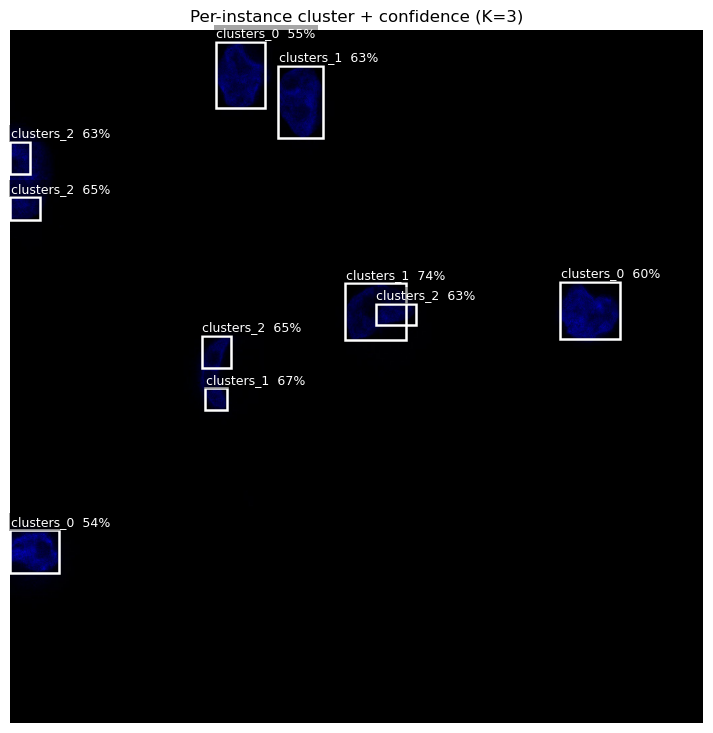

In [22]:
# =========================
# STEP 5 — Per-instance clustering overlay with inner-box removal
# =========================

# --- Imports ---
import math, numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import torch, torchvision.transforms as T
import timm

from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import opening, closing, dilation, remove_small_objects, remove_small_holes, disk
from skimage.measure import label, regionprops

from umap import UMAP  # used only if we must refit

# --- Parameters ---
SAMPLE_IMAGE = r"C:\Users\s229769\Downloads\cm4ai\cm4ai\untreated\blue\B2AI_5_untreated_H11_R1_z00_blue.jpg"

GAUSS_SIGMA   = 1.2
OPEN_FOOT     = 1
CLOSE_FOOT    = 3
MIN_OBJ_FRAC  = 0.0003
MIN_HOLE_FRAC = 0.0006
DILATE_FOOT   = 1
PAD_PIXELS    = 2

VIT_MODEL     = "vit_base_patch16_224"
VIT_SIZE      = 224
VIT_MEAN      = (0.485, 0.456, 0.406)
VIT_STD       = (0.229, 0.224, 0.225)

CONF_HIDE_TH  = 0.0   # hide labels below this prob
TEXT_OFFSET_PX = 14

# These should match Step 3
UMAP_NCOMP     = 32
UMAP_NEIGHBORS = 15
RANDOM_STATE   = 7

# --- Device & (re)instantiate ViT if not present ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    vit  # noqa
except NameError:
    vit = timm.create_model(VIT_MODEL, pretrained=True, num_classes=0).eval().to(device)

crop_tf = T.Compose([
    T.Resize((VIT_SIZE, VIT_SIZE), interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize(mean=VIT_MEAN, std=VIT_STD),
])

# --- Segmentation postprocess for per-image run ---
def seg_postprocess_local(probs):
    H, W = probs.shape
    p  = gaussian(probs, sigma=GAUSS_SIGMA, preserve_range=True)
    t  = threshold_otsu(p) * 0.9
    b0 = p > t
    b1 = opening(b0, footprint=disk(OPEN_FOOT))
    b2 = closing(b1, footprint=disk(CLOSE_FOOT))
    b3 = remove_small_objects(b2, min_size=max(64, int(MIN_OBJ_FRAC * H * W)))
    b4 = remove_small_holes(b3, area_threshold=max(128, int(MIN_HOLE_FRAC * H * W)))
    bf = dilation(b4, footprint=disk(DILATE_FOOT))
    return bf

def crop_from_bbox_local(pil_img, bbox):
    H, W = pil_img.size[1], pil_img.size[0]
    y0, x0, y1, x1 = bbox
    y0p, x0p = max(0, y0 - PAD_PIXELS), max(0, x0 - PAD_PIXELS)
    y1p, x1p = min(H, y1 + PAD_PIXELS), min(W, x1 + PAD_PIXELS)
    return pil_img.crop((x0p, y0p, x1p, y1p))

# --- Containment filtering (remove inner boxes) ---
def contained(inner, outer):
    yi0, xi0, yi1, xi1 = inner
    yo0, xo0, yo1, xo1 = outer
    return (yi0 >= yo0) and (xi0 >= xo0) and (yi1 <= yo1) and (xi1 <= xo1)

def filter_inner_boxes(props):
    # keep largest first; drop any box fully inside an already-kept box
    props_sorted = sorted(props, key=lambda r: r.area, reverse=True)
    kept, kept_bboxes = [], []
    for r in props_sorted:
        bb = r.bbox
        if any(contained(bb, kb) for kb in kept_bboxes):
            continue
        kept.append(r)
        kept_bboxes.append(bb)
    return kept

# --- Soft cluster confidence from UMAP space ---
def centroid_soft_conf(emb_umap, centers):
    dists = np.linalg.norm(centers - emb_umap[None, :], axis=1)  # [K]
    alpha = 1.0 / (np.std(dists) + 1e-6)
    sims = np.exp(-alpha * dists)
    sims = sims / (sims.sum() + 1e-9)
    cls = int(np.argmax(sims)); conf = float(np.max(sims))
    return cls, conf

# --- Load image, segment, and filter boxes ---
pil = Image.open(SAMPLE_IMAGE).convert("RGB")
x_img = T.ToTensor()(pil).unsqueeze(0).to(device)

# Expect `deeplab_vit` in scope
deeplab_vit.eval()
with torch.no_grad():
    logits = deeplab_vit(x_img)              # [1,1,H,W] expected
    probs  = torch.sigmoid(logits).cpu().squeeze().numpy()

bin_mask = seg_postprocess_local(probs)
lab = label(bin_mask)
props = filter_inner_boxes(list(regionprops(lab)))

# --- Ensure we have a fitted UMAP and KMeans ---
# Use existing fitted UMAP from Step 3 if available; else fit on X_feats.
try:
    umap  # noqa
    use_transform = hasattr(umap, "embedding_")
except NameError:
    use_transform = False

if not use_transform:
    # Fallback: fit a fresh UMAP on X_feats from Step 2
    try:
        umap = UMAP(n_components=UMAP_NCOMP, n_neighbors=UMAP_NEIGHBORS,
                    metric="cosine", random_state=RANDOM_STATE).fit(X_feats)
    except NameError as e:
        raise RuntimeError("UMAP is not fitted and X_feats is unavailable. Run Steps 2–3 first.") from e

# Ensure we have kmeans_final
try:
    kmeans_final  # noqa
except NameError as e:
    # Fallback quick K=3 if user didn’t run Step 3 (still usable for demo)
    from sklearn.cluster import KMeans
    kmeans_final = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10).fit(umap.embedding_)

# --- Overlay ---
fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(np.array(pil))

for r in props:
    y0, x0, y1, x1 = r.bbox
    crop = crop_from_bbox_local(pil, (y0, x0, y1, x1))
    xt = crop_tf(crop).unsqueeze(0).to(device)
    with torch.no_grad():
        f = vit(xt).squeeze(0).cpu().numpy()

    f_umap = umap.transform(f[None, :]).squeeze(0)
    cls, conf = centroid_soft_conf(f_umap, kmeans_final.cluster_centers_)
    if conf < CONF_HIDE_TH:
        continue

    rect = Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, linewidth=1.8, edgecolor='white')
    ax.add_patch(rect)
    ax.text(x0 + 2, max(y0 - TEXT_OFFSET_PX, 5),
            f"clusters_{cls}  {int(round(100*conf))}%",
            fontsize=9, color="white",
            bbox=dict(facecolor="black", alpha=0.35, pad=1.5, edgecolor="none"))

ax.set_title(f"Per-instance cluster + confidence (K={kmeans_final.n_clusters})")
ax.axis("off")
plt.show()
